This file calculates the Critial Radius 200 of a given subhalo.

In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import FunctionLib
#%matplotlib widget
basePath ='./sims.TNG/TNG50-1/output'
from tqdm import tqdm
import gc
import os


In [3]:
snapshot_num=99
lbsg_index_list=[117251,117254,300903,307486,324123,329508,342446,382215,383975,388544,400973,419618,434356,448830,457431,460722,462710,490814,507292,514272,529855]
m_dm=4.5E-5
h=0.6774
Critial_Density=1.27E-8
Critial_Density_h=Critial_Density/h**2


In [4]:
gas_fields=['Coordinates','Masses','Velocities']
dm_fields=['Coordinates','Velocities']
stars_fields=['Coordinates','Masses','Velocities']
bh_fields=['Coordinates','Masses','Velocities']

subhalo_fields=['SubhaloPos','SubhaloVel','SubhaloSpin','SubhaloCM','SubhaloMass']


In [10]:
for subhalo_id in lbsg_index_list:

    R,mass=R_200_Calculation(snapshot_num,subhalo_id,Critial_Density)
    deltaM=200*4/3*3.14*Critial_Density*R**3-mass
    print(mass,deltaM)


365.971 -5.18208392132
69.1571 -0.689125274681
1017.53 -44.0736934696
191.687 -2.11535056898
928.959 -65.0204239514
775.565 -23.3147023372
368.033 -16.9510377256
337.242 -8.12890902453
306.643 -10.1686493954
318.785 -28.0027056568
283.363 -11.9294140095
229.706 -13.4598034731
210.278 -12.0746008994
214.748 -3.11104486231
163.405 -11.4263621279
115.483 -12.169197996
180.837 -15.649852433
119.415 -2.80233499377
56.2568 -4.53173183544
87.282 -2.58219411404
69.4691 -2.07374481106


In [27]:
dm_angular_momentum.shape


(22461945, 3)

In [30]:
dm_relative_coordinates_tensor[22461944],dm_relative_velocities_tensor[22461944]


(array([ 273.31444538,  114.78976438,   71.94895586]),
 array([ 165.33383179, -355.72839355,  238.36895752], dtype=float32))

In [15]:
subhalo_spin


array([-8173.23730469,  -944.88470459, -1092.94482422], dtype=float32)

In [43]:
dm_angular_momentum


array([[  4.74492088e-01,  -2.28063250e+00,   7.67967365e-01],
       [  1.50170664e+00,   3.17512151e+00,  -6.33577693e+00],
       [  9.13560784e-01,  -8.31839011e-01,   1.08358083e+00],
       ..., 
       [  3.45392422e+04,  -1.02923096e+05,  -1.30326123e+04],
       [ -1.79166171e+04,   8.49221855e+03,   1.53210081e+05],
       [  5.29566030e+04,  -5.32540829e+04,  -1.16204340e+05]])

In [5]:
def R_200_Calculation(snapshot_num,subhalo_id,Critial_Density):

    subhalos_data=il.groupcat.loadSubhalos(basePath,snapshot_num,fields=subhalo_fields)
    subhalo_position=subhalos_data['SubhaloPos'][subhalo_id]
    subhalo_velocity=subhalos_data['SubhaloVel'][subhalo_id]
    subhalo_spin=subhalos_data['SubhaloSpin'][subhalo_id]
    subhalo_mass=subhalos_data['SubhaloMass'][subhalo_id]


    gas_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,0,fields=gas_fields)
    dm_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,1,fields=dm_fields)
    stars_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,4,fields=stars_fields)
    bh_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,5,fields=bh_fields)


    precision = 1
    max_iter = 100
    left, right = 0, 1000

    for i in range(max_iter):

        mid = (left + right) / 2

        mass_in=total_mass_in_radius(gas_data_tensor,dm_data_tensor,stars_data_tensor,bh_data_tensor,subhalo_position,mid)

        density=3*mass_in/(4*3.14*mid**3)

        if density > 200*Critial_Density:
            left = mid

        else:
            right = mid


        if abs(right - left) < precision or i == max_iter - 1:
            R_200 = (left + right) / 2
            break

    return R_200,subhalo_mass

def baryon_mass_in_radius(Center,Radius,Coordinates,Masses):
    dist_to_com = np.sqrt(np.sum((Coordinates - Center)**2, axis=1))
    within_radius_idx = np.where(dist_to_com <= Radius)[0]
    total_mass_within_radius = np.sum(Masses[within_radius_idx])
    return total_mass_within_radius

def dm_mass_in_radius(Center,Radius,Coordinates):
    dist_to_com = np.sqrt(np.sum((Coordinates - Center)**2, axis=1))
    within_radius_idx = np.where(dist_to_com <= Radius)[0]
    total_mass_within_radius = m_dm*within_radius_idx.shape[0]*h
    return total_mass_within_radius

def total_mass_in_radius(gas_data_tensor,dm_data_tensor,stars_data_tensor,bh_data_tensor,Center,Radius):

    gas_mass_in=baryon_mass_in_radius(Center,Radius,gas_data_tensor['Coordinates'],gas_data_tensor['Masses'])
    dm_mass_in=dm_mass_in_radius(Center,Radius,dm_data_tensor['Coordinates'])
    stars_mass_in=baryon_mass_in_radius(Center,Radius,stars_data_tensor['Coordinates'],stars_data_tensor['Masses'])
    bh_mass_in=baryon_mass_in_radius(Center,Radius,bh_data_tensor['Coordinates'],bh_data_tensor['Masses'])

    total_mass_in=gas_mass_in+dm_mass_in+stars_mass_in+bh_mass_in

    return total_mass_in

def cal_dm_angular_momentum(Position,Velocity,DM_Data_Tensor,R_virial):


    DM_Coordinates,DM_Velocities=DM_Data_Tensor['Coordinates'],DM_Data_Tensor['Velocities']

    dm_relative_velocities_tensor=DM_Velocities-Velocity
    dm_relative_coordinates_tensor=DM_Coordinates-Position
    dm_particle_number=dm_relative_coordinates_tensor.shape[0]
    dm_particle_distance=calculate_distance(dm_relative_coordinates_tensor)

    cross_product=np.cross(dm_relative_coordinates_tensor,dm_relative_velocities_tensor)
    index=np.where(dm_particle_distance>R_virial)[0]

    for i in index:
        cross_product[i]=0


    dm_angular_momentum=(cross_product/dm_particle_number).sum(axis=0)

    return dm_angular_momentum

def calculate_distance(array):
    squared=np.square(array)

    sum=squared.sum(axis=1)
    sum=np.sqrt(sum)
    return sum

def cal_baryon_angular_momentum(Position,Velocity,Baryon_Data_Tensor,R_virial):

    Baryon_Coordinates,Baryon_Velocities,Baryon_Masses=Baryon_Data_Tensor['Coordinates'],Baryon_Data_Tensor['Velocities'],Baryon_Data_Tensor['Masses']

    baryon_relative_velocities_tensor=Baryon_Velocities-Velocity
    baryon_relative_coordinates_tensor=Baryon_Coordinates-Position
    baryon_particle_distance=calculate_distance(baryon_relative_coordinates_tensor)

    cross_product=np.cross(baryon_relative_coordinates_tensor,baryon_relative_velocities_tensor)

    index=np.where(baryon_particle_distance>R_virial)[0]

    for i in index:
        cross_product[i]=0

    angular_momentum=(Baryon_Masses.reshape(-1,1)*cross_product).sum(axis=0)
    weight_angular_momentum=(angular_momentum/Baryon_Masses.sum())

    return weight_angular_momentum


In [6]:
R_200_Calculation(99,329508,Critial_Density_h)


(306.15234375, 775.56519)

In [7]:
200*4/3*3.14*Critial_Density_h*306**3


664.0121041767839

In [5]:
subhalos_data=il.groupcat.loadSubhalos(basePath,snapshot_num,fields=subhalo_fields)
subhalo_id=329508
subhalo_position=subhalos_data['SubhaloPos'][subhalo_id]
subhalo_velocity=subhalos_data['SubhaloVel'][subhalo_id]
subhalo_spin=subhalos_data['SubhaloSpin'][subhalo_id]
subhalo_mass=subhalos_data['SubhaloMass'][subhalo_id]


In [6]:
gas_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,0,fields=gas_fields)
dm_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,1,fields=dm_fields)
stars_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,4,fields=stars_fields)
bh_data_tensor=il.snapshot.loadSubhalo(basePath,snapshot_num,subhalo_id,5,fields=bh_fields)


In [35]:
stars_data_tensor['Masses'].sum()


32.727501

In [52]:
gas_am=cal_baryon_angular_momentum(subhalo_position,subhalo_velocity,gas_data_tensor,1000)
gas_am


array([-12810.02010014,  -5556.29439779,   1091.57925781])

In [53]:
dm_am=cal_dm_angular_momentum(subhalo_position,subhalo_velocity,dm_data_tensor,1000)
dm_am


array([-8059.38031915,  -677.92625242, -1328.51657136])

In [54]:
stars_am=cal_baryon_angular_momentum(subhalo_position,subhalo_velocity,stars_data_tensor,1000)
stars_am


array([-3171.15469077,   800.50094809,   379.01172569])

In [55]:
bh_am=cal_baryon_angular_momentum(subhalo_position,subhalo_velocity,bh_data_tensor,1000)
bh_am


array([-0.07306994, -0.03714474,  0.03114455])

In [19]:
subhalo_spin


array([-8173.23730469,  -944.88470459, -1092.94482422], dtype=float32)

In [51]:
(gas_am*gas_data_tensor['Masses'].sum()+dm_am*dm_data_tensor['Coordinates'].shape[0]*m_dm/h+stars_am*stars_data_tensor['Masses'].sum()+bh_am*bh_data_tensor['Masses'].sum())/(gas_data_tensor['Masses'].sum()+dm_data_tensor['Coordinates'].shape[0]*m_dm/h+stars_data_tensor['Masses'].sum()+bh_data_tensor['Masses'].sum())


array([-7730.00353778,  -655.11012447, -1209.96403127])

In [56]:
(gas_am*gas_data_tensor['Masses'].sum()+dm_am*dm_data_tensor['Coordinates'].shape[0]*m_dm/h+stars_am*stars_data_tensor['Masses'].sum()+bh_am*bh_data_tensor['Masses'].sum())/(gas_data_tensor['Masses'].sum()+dm_data_tensor['Coordinates'].shape[0]*m_dm/h+stars_data_tensor['Masses'].sum()+bh_data_tensor['Masses'].sum())


array([-8115.36389529,  -809.18962843, -1212.68606901])

In [38]:
dm_data_tensor['Coordinates'].shape[0]


22461945

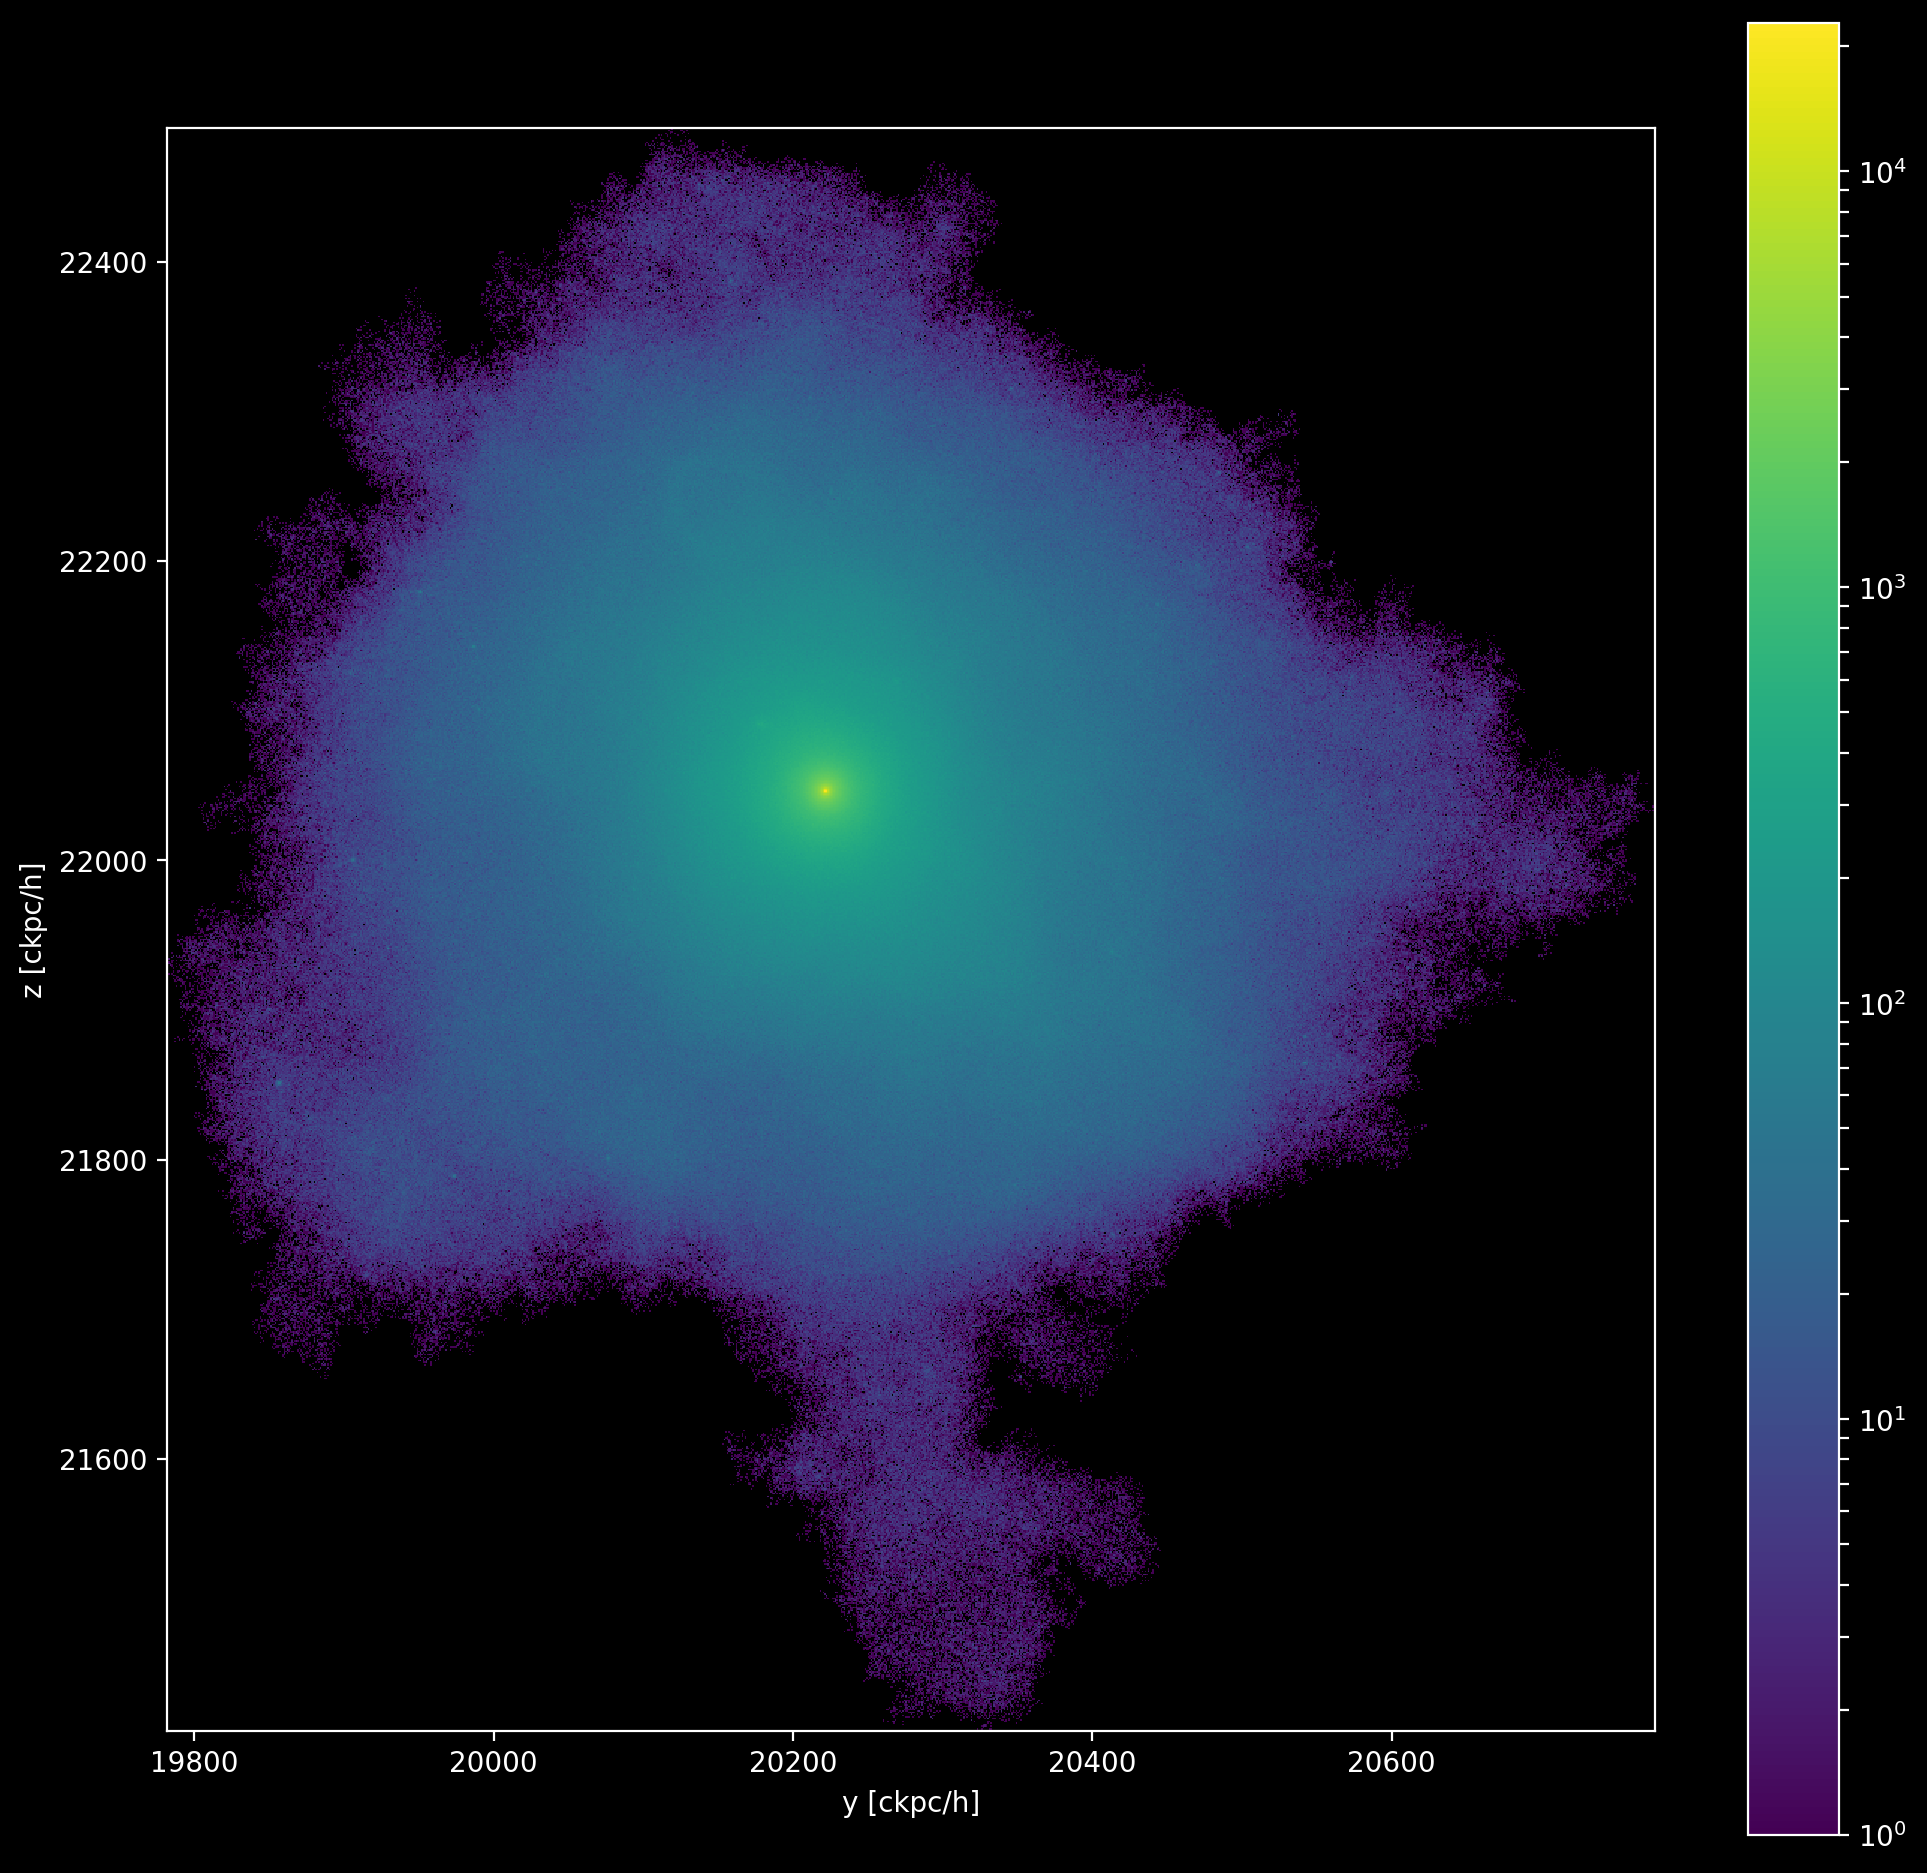

In [66]:
def drawdmsubhalo(i,sp,basePath):
    dm_data=il.snapshot.loadSubhalo(basePath, sp, i, 1, fields=['Coordinates'])


    GasCoorMin = dm_data.min(axis=0)
    GasCoorMax = dm_data.max(axis=0)
    CircleCenter = (GasCoorMin + GasCoorMax) / 2
    plt.figure(figsize=(12, 12), dpi=200)

    plt.style.use("dark_background")
    bars=(GasCoorMax-GasCoorMin)
    h, _, _, image = plt.hist2d(dm_data[:, 1],
                            dm_data[:, 2],

                            norm=mpl.colors.LogNorm(),
                            bins=(bars[1],bars[2]))
    plt.xlim([GasCoorMin[1],GasCoorMax[1]])
    plt.ylim([GasCoorMin[2],GasCoorMax[2]])
    plt.xlabel('y [ckpc/h]')
    plt.ylabel('z [ckpc/h]')
    #draw_circle = plt.Circle(( CircleCenter[1],  CircleCenter[2]), 150, fill=False)
    #plt.gcf().gca().add_artist(draw_circle)
    plt.colorbar(image)
    plt.gca().set_aspect(1)
    plt.show()

drawdmsubhalo(329508,99,basePath)
